# Asymptotic Form of the MLE

## Recap

We have been working with a probability model and likelihood function for a simple one bin counting experiment with $n$ observed, $s$ expected signal, and $b$ expected background events in our signal region and $m$ observed and $b$ expected background events, in our control region, with the signal strength parametrized by $\mu$:

$$
P(n, m; \mu s, b) = \frac{(\mu s+b)^n e^{-(\mu s+b)}}{n!} \cdot \frac{b^m e^{-b}}{m!} = L(
\mu, b),
$$ (5model)

The negative-log-likelihood (NLL) is:

```{math}
:label: 5nll
-\ln L = \ln n! + \ln m! + \mu s + 2b - n\ln(\mu s+b) - m \ln b
```

Code from previous parts:

In [9]:
import numpy as np
import matplotlib
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, chi2
import warnings
from IPython.display import display, Latex

plt.rcParams.update({"font.size": 16})
warnings.filterwarnings("ignore")

In [4]:
def log_poisson_nofactorial(n, mu):
    return -mu + n * np.log(mu)


def log_likelihood_nofactorial(s, b, n, m):
    return log_poisson_nofactorial(n, s + b) + log_poisson_nofactorial(m, b)


def shat(n, m):
    return n - m


def bhat(n, m):
    return m


def bhathat(s, n, m):
    """Using the quadratic formula and only the positive solution"""
    return ((n + m - 2 * s) + np.sqrt((n + m - 2 * s) ** 2 + 8 * s * m)) / 4


def t_s(s, n, m, b=None):
    """-2ln(lambda), b can optionally be fixed (for demo below)"""
    bhh, bh = (bhathat(s, n, m), bhat(n, m)) if b is None else (b, b)
    return -2 * (
        log_likelihood_nofactorial(s, bhh, n, m) - log_likelihood_nofactorial(shat(n, m), bh, n, m)
    )


def t_zero_s(s, n, m):
    """Alternative test statistic when shat < 0"""
    return -2 * (
        log_likelihood_nofactorial(s, bhathat(s, n, m), n, m)
        - log_likelihood_nofactorial(0, bhathat(0, n, m), n, m)
    )


def t_tilde_s(s, n, m):
    #     s, n, m = [np.array(x) for x in (s, n, m)]  # convert to numpy arrays
    neg_shat_mask = shat(n, m) < 0  # find when s^ is < 0
    ts = np.array(t_s(s, n, m))
    t_zero = t_zero_s(s, n, m)
    # replace values where s^ < 0 with lam_zero
    ts[neg_shat_mask] = t_zero[neg_shat_mask]
    return ts.squeeze()


def q_tilde_s(s, n, m):
    ts = np.array(t_s(s, n, m))

    neg_shat_mask = shat(n, m) < 0  # find when s^ is < 0
    t_zero = t_zero_s(s, n, m)
    # replace values where s^ < 0 with lam_zero
    ts[neg_shat_mask] = t_zero[neg_shat_mask]

    upper_shat_mask = shat(n, m) > s
    ts[upper_shat_mask] = 0

    return ts.squeeze()

In [5]:
def get_toys_sb(s, b, num_toys):
    """Generate toy data for a given s and b"""
    # sample n, m according to our data model (Eq. 1)
    n, m = poisson.rvs(s + b, size=num_toys), poisson.rvs(b, size=num_toys)
    return n, m


def get_toys(s, n_obs, m_obs, num_toys):
    """Generate toy data for a given s and observed n and m"""
    #  use b^^ for p(t_s|s) as recommended by Ref. 2
    b = bhathat(s, n_obs, m_obs)
    return get_toys_sb(s, b, num_toys)


def get_p_ts(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """
    Get the t_tilde_s test statistic distribution via toys.
    By default, the s we're testing is the same as the s we're using for toys,
    but this can be changed if necessary (as you will see later).
    """
    if toy_s is None:
        toy_s = test_s
    n, m = get_toys(toy_s, n_obs, m_obs, num_toys)
    return t_tilde_s(test_s, n, m)


def get_ps_val(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """p value"""
    t_tilde_ss = get_p_ts(test_s, n_obs, m_obs, num_toys, toy_s)
    t_obs = t_tilde_s(test_s, n_obs, m_obs)
    p_val = np.mean(t_tilde_ss > t_obs)
    return p_val, t_tilde_ss, t_obs


def get_p_qs(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """
    Get the q_tilde_s test statistic distribution via toys.
    By default, the s we're testing is the same as the s we're using for toys,
    but this can be changed if necessary (as you will see later).
    """
    if toy_s is None:
        toy_s = test_s
    n, m = get_toys(toy_s, n_obs, m_obs, num_toys)
    return q_tilde_s(test_s, n, m)


def get_pval_qs(test_s, n_obs, m_obs, num_toys, toy_s=None):
    """p value"""
    q_tilde_ss = get_p_qs(test_s, n_obs, m_obs, num_toys, toy_s)
    q_obs = q_tilde_s(test_s, n_obs, m_obs)
    p_val = np.mean(q_tilde_ss > q_obs)
    return p_val, q_tilde_ss, q_obs


def get_limits_CLs(s_scan: list, n_obs: int, m_obs: int, num_toys: int, CL: float = 0.95):
    p_cls_scan = []  # saving p-value for each s

    for s in s_scan:
        p_mu, t_tilde_sb, t_obs = get_ps_val(s, n_obs, m_obs, num_toys)
        p_b, t_tilde_sb, t_obs = get_ps_val(s, n_obs, m_obs, num_toys, toy_s=0)
        p_b = 1 - p_b
        p_cls_scan.append(p_mu / (1 - p_b))

    # find the values of s that give p_value ~= 1 - CL
    pv_cl_diff = np.abs(np.array(p_cls_scan) - (1 - CL))
    half_num_s = int(len(s_scan) / 2)
    s_low = s_scan[np.argsort(pv_cl_diff[:half_num_s])[0]]
    s_high = s_scan[half_num_s:][np.argsort(pv_cl_diff[half_num_s:])[0]]

    return s_low, s_high


def get_upper_limit_CLs(s_scan: list, n_obs: int, m_obs: int, num_toys: int, CL: float = 0.95):
    p_cls_scan = []  # saving p-value for each s

    for s in s_scan:
        p_mu, q_tilde_sb, q_obs = get_pval_qs(s, n_obs, m_obs, num_toys)
        p_b, q_tilde_sb, q_obs = get_pval_qs(s, n_obs, m_obs, num_toys, toy_s=0)
        p_b = 1 - p_b
        p_cls_scan.append(p_mu / (1 - p_b))

    # find the values of s that give p_value ~= 1 - CL
    pv_cl_diff = np.abs(np.array(p_cls_scan) - (1 - CL))
    s_upper = s_scan[np.argsort(pv_cl_diff)[0]]

    return s_upper

## Introduction

So far, we have discussed how to extract meaningful statistical results from HEP experiments by making extensive use of pseudodata / toy experiments to estimate the sampling distributions of profile-likelihood-ratio-based test statistics.
While this worked nicely for our simple counting experiment, generating a sufficiently large number of toys can quickly become computationally intractable for the more complex searches (and statistical combinations of searches) that are increasingly prevalent at the LHC, containing at times up to thousands of bins and nuisance parameters.
This and the following section discuss a way to approximate these sampling distributions without the need for pseudodata.
This was introduced in the famous "CCGV" paper {cite}`Cowan:2010js` in 2011, and has since become the de-facto procedure at the LHC.

```{margin}
See e.g. {numref}`2p_tilde_t_asym` and {numref}`3p_tilde_q`.
```

As previously discussed, the distributions $p(\tilde{t}_\mu|\mu')$ and $p(\tilde{q}_\mu|\mu')$ (where, in general, $\mu' \neq \mu$) have similar forms regardless of the nuisance parameters (or sometimes even the POIs).
This is not a coincidence: we will now derive their "asymptotic", i.e. in the large sample limit, forms, starting first with asymptotic form of the maximum likelihood estimator (MLE).

It is important to remember that the MLE $\hat \mu$ of $\mu$ is a random variable with its own probability distribution. We can estimate it as always by sampling toys:

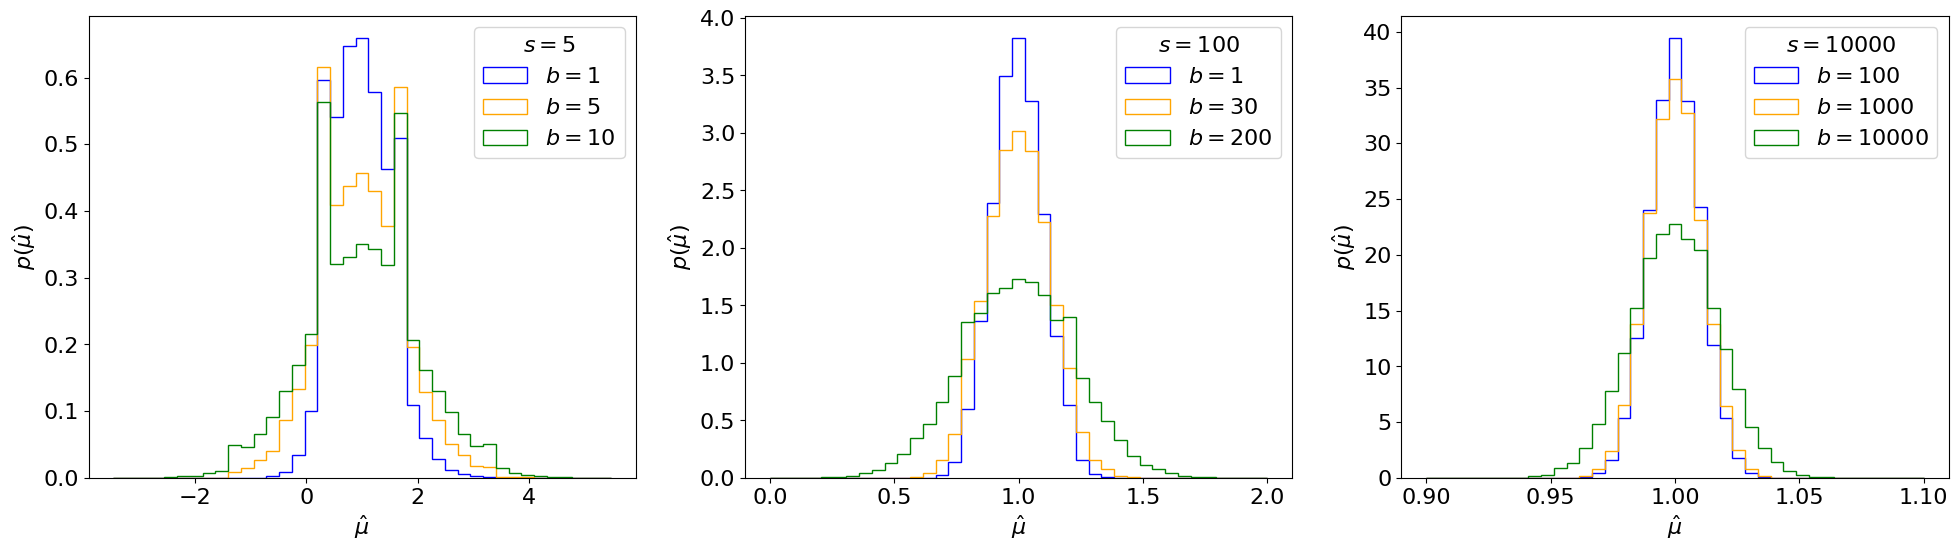

In [5]:
num_toys = 30000
sbs = [
    [(5.0, 1.0), (5.0, 5.0), (5.0, 10.0)],
    [(100, 1), (100, 30), (100, 200)],
    [(10000, 100), (10000, 1000), (10000, 10000)],
]
colours = ["blue", "orange", "green"]

fig, axs = plt.subplots(1, 3, figsize=(24, 6))
plt.rcParams.update({"font.size": 16})
for i, sb in enumerate(sbs):
    for j, (s, b) in enumerate(sb):
        n, m = get_toys_sb(s, b, num_toys)
        axs[i].hist(
            shat(n, m) / s,
            np.linspace(1 - 10 / np.sqrt(s), 1 + 10 / np.sqrt(s), 40),
            histtype="step",
            density=True,
            label=rf"$b = {int(b)}$",
            color=colours[j],
        )

    axs[i].legend(title=f"$s = {s:.0f}$")
    axs[i].set_xlabel(r"$\hat \mu$")
    axs[i].set_ylabel(r"$p(\hat \mu)$")

plt.show()

You may notice that $p(\hat \mu)$ follows a Gaussian as the number of events $N$ increases:

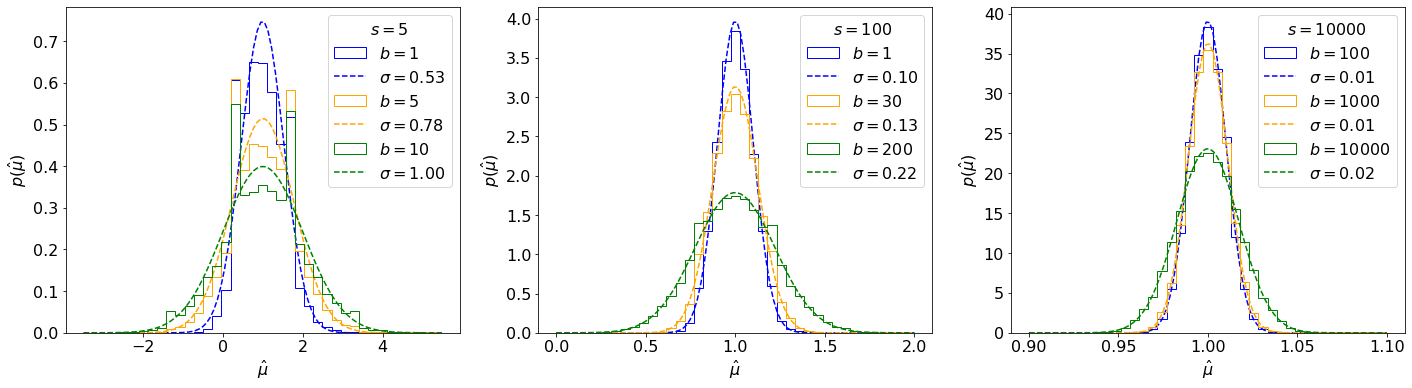

In [5]:
num_toys = 30000
sbs = [
    [(5.0, 1.0), (5.0, 5.0), (5.0, 10.0)],
    [(100, 1), (100, 30), (100, 200)],
    [(10000, 100), (10000, 1000), (10000, 10000)],
]
colours = ["blue", "orange", "green"]

fig, axs = plt.subplots(1, 3, figsize=(24, 6))
for i, sb in enumerate(sbs):
    for j, (s, b) in enumerate(sb):
        n, m = get_toys_sb(s, b, num_toys)
        muh = shat(n, m) / s

        xl, xr = 1 - 10 / np.sqrt(s), 1 + 10 / np.sqrt(s)
        x = np.linspace(xl, xr, 100)
        axs[i].hist(
            muh,
            np.linspace(xl, xr, 40),
            histtype="step",
            density=True,
            label=rf"$b = {int(b)}$",
            color=colours[j],
        )

        mean, std = norm.fit(muh)
        axs[i].plot(
            x,
            norm.pdf(x, mean, std),
            color=colours[j],
            linestyle="--",
            label=rf"$\sigma = {std:.2f}$",
        )

    axs[i].legend(title=f"$s = {s:.0f}$")
    axs[i].set_xlabel(r"$\hat \mu$")
    axs[i].set_ylabel(r"$p(\hat \mu)$")

plt.show()

We will now show this to be true generally. You are welcome to skip ahead to the {ref}`result <result>` if you're not interested in the derivation.

## Background statistics

First, we need some statistics concepts and results:

```{margin}
See derivations in e.g. [Wikipedia](https://en.wikipedia.org/wiki/Informant_(statistics)#Properties).
```

```{margin}
Note that expectation value means an average over observations which are distributed according to a particular $\mu$, which here we're calling the "true" $\mu$: $\mu'$.
```

````{admonition} Lightning Statistics
:class: tip

Let the log-likelihood $\ln L(\mu) \equiv l(\mu)$. 

The derivative of the NLL $-l'(\mu)$ is called the **score** $s(\mu)$. It has a number of useful properties:
1. Its expectation value at $\mu'$: $\mathbb E_{\mu = \mu'}[s(\mu')] = 0$.
2. Its variance $\mathrm {Var} [s(\mu)] = - \mathbb E [l''(\mu)]$.

$- \mathbb E [l''(\mu)] \equiv \mathcal I(\mu)$ is called the **Fisher information**. 
It quantifies the information our data contains about $\mu$ and importantly, as we'll see, it (approximately) represents the inverse of the variance of $\hat \mu$.
More generally, for multiple parameters, $\mathcal I_{ij}(\mu) = - \mathbb E [\frac{\partial^2 l}{\partial \mu_i \partial \mu_j}]$ is the Fisher information matrix.
It is also commonly called the **covariance matrix**.

Putting this together, by the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), this means $p(s(\mu'))$ follows a normal distribution with mean 0 and variance $\mathcal I(\mu')$, up to terms of order $\mathcal O(\frac{1}{\sqrt{N}})$:

$$
s(\mu') \xrightarrow{\sqrt{N} >> 1} \mathcal N(0, \sqrt{\mathcal I(\mu')}),
$$ (5score)

where $N$ represents the data sample size.
````

### Fisher Information

For our simple counting experiment, the Fisher information matrix $\mathcal I(\mu, b)$ can be found by taking second derivatives of Eq. {eq}`5nll`. The $\mathcal I_{\mu\mu}$ term, for example, is:

$$
    \mathcal I_{\mu\mu}(\mu, b) = - \mathbb E[\partial^\mu\partial^\mu l(\mu, b)] = \mathbb E \bigg[n \cdot \cfrac{s^2}{(\mu s + b)^2}\bigg] = \mathbb E[n] \cdot \cfrac{s^2}{(\mu s + b)^2} = \cfrac{(\mu' s + b') s^2}{(\mu s + b)^2}.
$$ (5fisher)

In the last step we use the fact that $\mathbb E[n]$ under true $\mu = \mu', b = b'$, is $\mu' s + b'$.
For the remainder of this section, $\mathcal I(\mu, b)$ will always be evaluated at the true values of the parameters (the reason for this is discussed below), so this can be simplified to $\mathcal I_{\mu\mu}(\mu', b') = \frac{s^2}{\mu' s + b'}$.

This is what it looks like:

In [6]:
def get_fisher_mu_mu(mu, s, b):
    # assuming here that mu and b equal their true values
    return (s**2) / (mu * s + b)

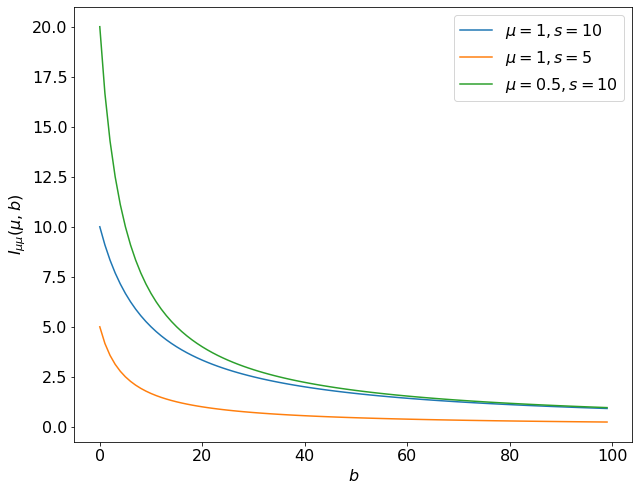

In [7]:
mus = [(1, 10), (1, 5), (0.5, 10)]
b = np.arange(0, 100, 1)

fig, ax = plt.subplots(figsize=(10, 8))

for mu, s in mus:
    ax.plot(b, get_fisher_mu_mu(mu, s, b), label=rf"$\mu = {mu}, s = {s}$")

ax.legend()
ax.set_ylabel(r"$I_{{\mu\mu}}(\mu, b)$")
ax.set_xlabel("$b$")
plt.show()

The Fisher information captures the fact that as $b$ increases, we lose sensitivity to - or *information* about - $\mu$. Exercise 🙃: why are the orange and green values different? 

For completeness (and since we'll need it below) the full Fisher information matrix for our problem, repeating the steps in Eq. {eq}`5fisher`, is:

$$
    \mathcal I(\mu', b')
    = \begin{pmatrix}\mathcal I_{\mu\mu} & \mathcal I_{\mu b} \\ \mathcal I_{b\mu} & \mathcal I_{bb}\end{pmatrix}(\mu', b')
    = \begin{pmatrix}
    \frac{s^2}{\mu' s + b'} & \frac{s}{\mu' s + b'} \\ \frac{s}{\mu' s + b'} & \frac{1}{\mu' s + b'} + \frac{1}{b'}
    \end{pmatrix}
$$ (5fishermatrix)

## Derivation

```{margin}
For a more rigorous derivation, see e.g. this [post](https://gregorygundersen.com/blog/2019/11/28/asymptotic-normality-mle/).
```

We now have enough background to derive the asymptotic form of the MLE. 
We do this for the 1D case by Taylor-expanding the score of $\hat \mu$, $l'(\hat\mu)$ - which we know to be $ = 0$ - around $\mu'$:

$$
    l'(\hat\mu) = l'(\mu') + l''(\mu')(\hat\mu - \mu') + \mathcal O((\hat\mu - \mu')^2) = 0 \\
    \Rightarrow \hat\mu - \mu' \simeq - \cfrac{l'(\mu')}{l''(\mu')} \xrightarrow{\sqrt{N} >> 1} \cfrac{1}{\mathcal I(\mu')}N(0, \sqrt{\mathcal I(\mu')}) = N\bigg(0, \frac{1}{\sqrt{\mathcal I(\mu')}}\bigg),
$$ (5taylorl)

where we plugged in the distribution of $l'(\mu')$ from Eq. {eq}`5score`, claimed $l''(\mu')$ asymptotically equals its expectation value $\mathbb E[l''(\mu')] = \mathcal I(\mu')$ by the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers), and are ignoring the $\mathcal O((\hat\mu - \mu')^2)$ term.

For multiple parameters, $\mathcal I$ is a matrix so the variance is its matrix inverse:

$$
    \hat\mu - \mu' \simeq N(0, \sqrt{\mathcal I^{-1}_{\mu\mu}(\mu', b')}),
$$ (5asym_std_fisher)

(result)=
## Result

Thus, we see that $\hat \mu$ asymptotically follows a normal distribution around the true $\mu$ value, $\mu'$, with a variance $\sigma_{\hat\mu}^2 = \mathcal I^{-1}_{\mu\mu}(\mu', b')$, up to $\mathcal O (1/\sqrt{N})$ terms.
Intuitively, from the definition of the Fisher information $\mathcal I$, we can interpret this as saying that the more information we have about $\mu$ from the data, the lower the variance should be on $\hat \mu$.

For our counting experiment, inverting $\mathcal I$ from Eq. {eq}`5fishermatrix` gives us

$$
    \sigma_{\hat\mu} = \sqrt{\mathcal I^{-1}_{\mu\mu}(\mu', b')} = \cfrac{\sqrt{\mu' s + 2b'}}{s}.
$$ (5asymstd)

```{note}
Note that, as we might expect, this scales as $\sim \sqrt{b}$, which is the uncertainty of our Poisson nuisance parameter $b$ - showing mathematically why we want to keep uncertainties on nuisance parameters as low as possible.
```

Let's see how closely this matches the toy-based distributions from earlier, this time varying the true signal strength $\mu'$ as well:

In [7]:
def get_asym_std(mu, s, b):
    """Inputs should be the "true" mu and b values"""
    return np.sqrt(mu * s + 2 * b) / s

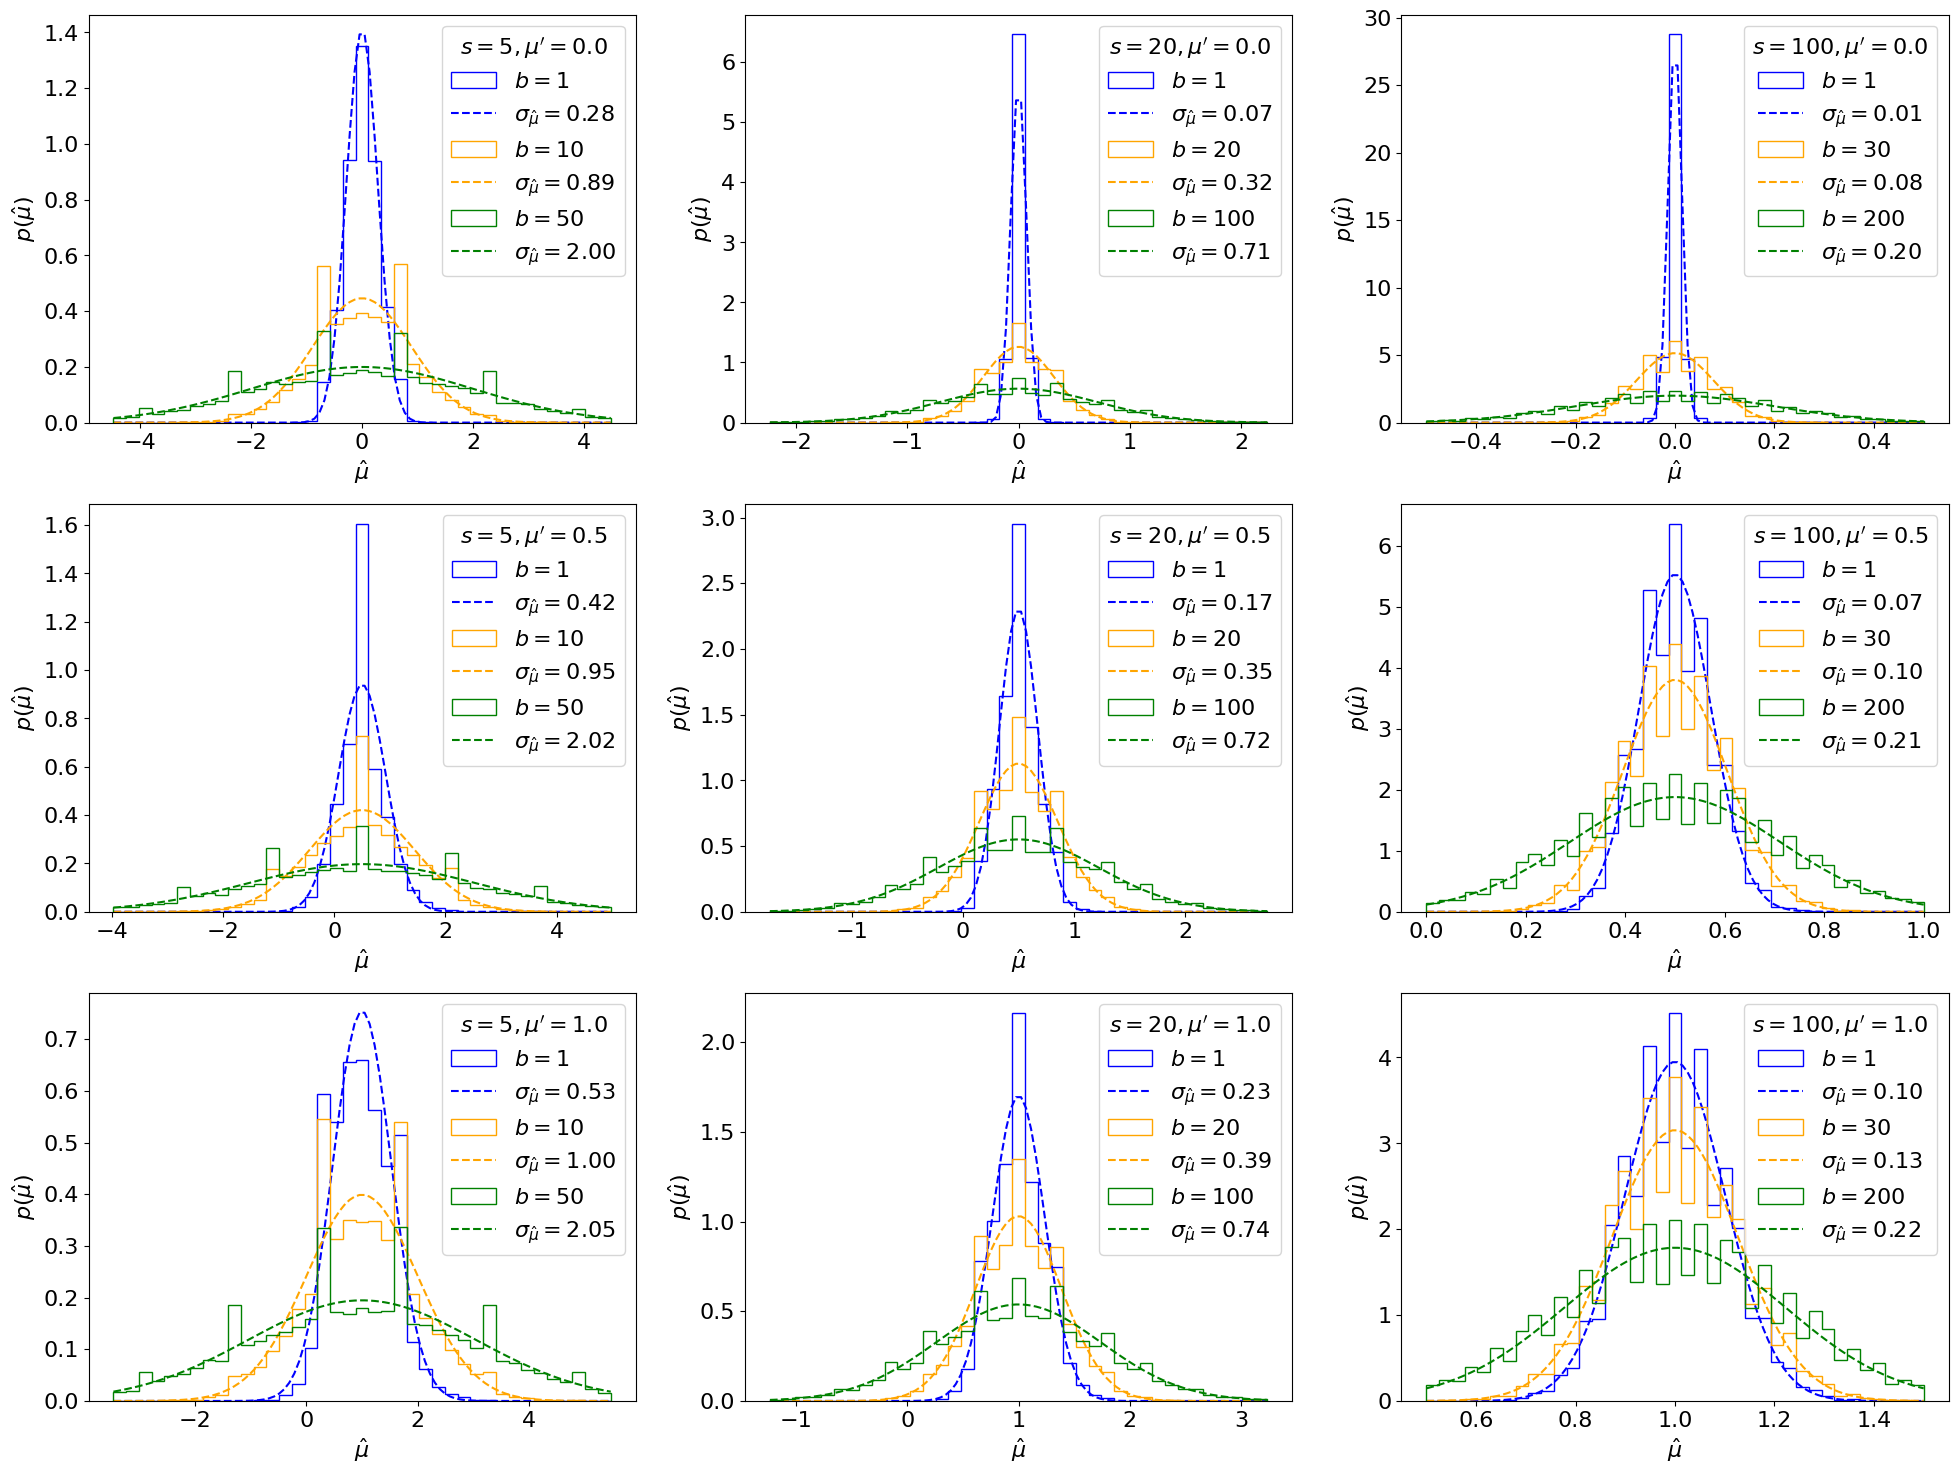

In [18]:
num_toys = 30000
sbs = [
    [(5.0, 1.0), (5.0, 10.0), (5.0, 50.0)],
    [(20, 1), (20, 20), (20, 100)],
    [(100, 1), (100, 30), (100, 200)],
    # [(10000, 100), (10000, 1000), (10000, 10000)],
]
colours = ["blue", "orange", "green"]
muprimes = [0, 0.5, 1.0]  # true mu

fig, axss = plt.subplots(len(muprimes), 3, figsize=(24, 6 * len(muprimes)))
for k, muprime in enumerate(muprimes):
    axs = axss[k]
    for i, sb in enumerate(sbs):
        for j, (s, b) in enumerate(sb):
            n, m = get_toys_sb(s * muprime, b, num_toys)
            muh = shat(n, m) / s

            xrange = 10 / np.sqrt(s) if i < 2 else 5 / np.sqrt(s)
            xl, xr = muprime - xrange, muprime + xrange
            x = np.linspace(xl, xr, 100)
            axs[i].hist(
                muh,
                np.linspace(xl, xr, 40),
                histtype="step",
                density=True,
                label=rf"$b = {int(b)}$",
                color=colours[j],
            )

            std = get_asym_std(muprime, s, b)
            axs[i].plot(
                x,
                norm.pdf(x, muprime, std),
                color=colours[j],
                linestyle="--",
                label=rf"$\sigma_{{\hat\mu}} = {std:.2f}$",
            )

        axs[i].legend(title=f"$s = {s:.0f}, \mu' = {muprime:.1f}$")
        axs[i].set_xlabel(r"$\hat \mu$")
        axs[i].set_ylabel(r"$p(\hat \mu)$")

plt.show()

We see that this matches well, generally, for large $s, b$, while for small values there are more significant differences. We can also check the total per-bin errors between the asymptotic form and the toy-based distributions directly (showing here only for $\mu' = 1$):

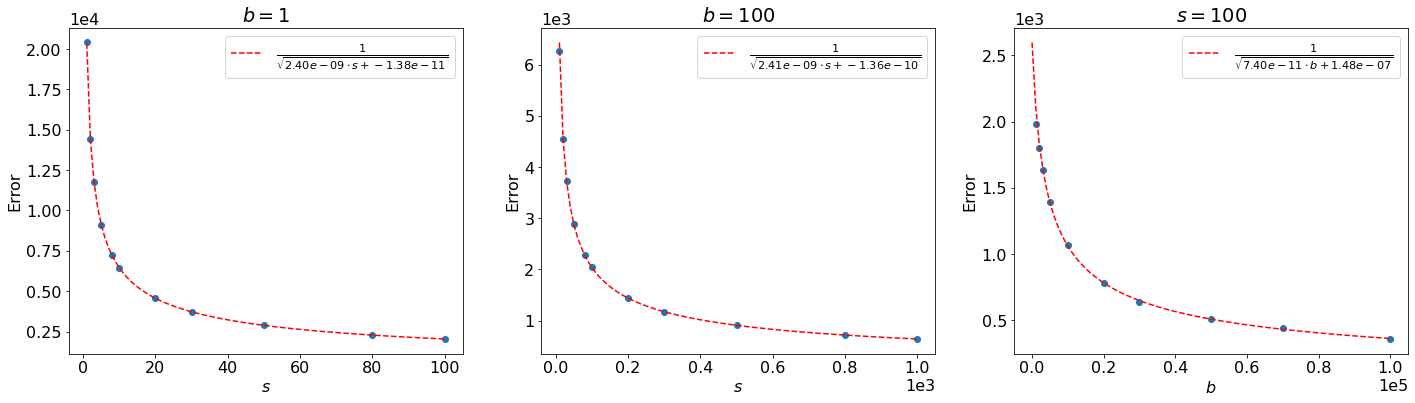

In [10]:
num_toys = 50000

# sample ranges of s's and fixed b's
sbs = [
    (np.array([1, 2, 3, 5, 8, 10, 20, 30, 50, 80, 100]), 1),
    (np.array([1, 2, 3, 5, 8, 10, 20, 30, 50, 80, 100]) * 10, 100),
    # (np.array([1, 2, 3, 5, 8, 10, 20, 30]) * 10000, 10000),
]

fig, axs = plt.subplots(1, 3, figsize=(24, 6))

for i, (s, b) in enumerate(sbs):
    errors = []
    for st in s:
        n, m = get_toys_sb(st, b, num_toys)
        muh = shat(n, m) / st
        xl, xr = 1 - 10 / np.sqrt(st), 1 + 10 / np.sqrt(st)
        edges = np.linspace(xl, xr, 50)
        midpoints = 0.5 * (edges[:-1] + edges[1:])
        bin_width = edges[1] - edges[0]
        # toy distribution
        toy_vals = np.histogram(muh, edges)[0]
        # asymptotic values at the midpoints of the toy distribution histogram
        asym_vals = norm.pdf(midpoints, 1, get_asym_std(1, st, b))
        # sum the absolute difference at each point * bin width
        error = np.sum(np.abs((toy_vals - asym_vals) * bin_width))
        errors.append(error)

    ax = axs[i]
    ax.scatter(s, errors)
    ax.set_ylabel("Error")
    ax.set_title(rf"$b = {b}$")
    ax.set_xlabel(r"$s$")
    ax.ticklabel_format(style="sci", scilimits=(-3, 3))

    # 1 / sqrt(s) fit (practically it's easier to do a linear fit to 1 / error^2)
    fit = np.polyfit(s, 1 / np.power(errors, 2), 1)
    x = np.linspace(0, s[-1], 100)
    ax.plot(
        x,
        1 / np.sqrt(np.poly1d(fit)(x)),
        color="red",
        linestyle="--",
        label=rf"$\frac{{1}}{{\sqrt{{{fit[0]:.2e} \cdot s + {fit[1]:.2e}}}}}$",
    )
    ax.legend()

# plot versus b
s, bs = 100, np.array([1000, 2000, 3000, 5000, 10000, 20000, 30000, 50000, 70000, 100000])

errors = []
for b in bs:
    n, m = get_toys_sb(s, b, num_toys)
    muh = shat(n, m) / s
    xl, xr = 1 - 10 / np.sqrt(s), 1 + 10 / np.sqrt(s)
    edges = np.linspace(xl, xr, 50)
    midpoints = 0.5 * (edges[:-1] + edges[1:])
    bin_width = edges[1] - edges[0]
    # toy distribution
    toy_vals = np.histogram(muh, edges)[0]
    # asymptotic values at the midpoints of the toy distribution histogram
    asym_vals = norm.pdf(midpoints, 1, get_asym_std(1, s, b))
    # sum the absolute difference at each point * bin width
    error = np.sum(np.abs((toy_vals - asym_vals) * bin_width))
    errors.append(error)

ax = axs[-1]
ax.scatter(bs, errors)
ax.set_ylabel("Error")
ax.set_title(rf"$s = {s}$")
ax.set_xlabel(r"$b$")
ax.ticklabel_format(style="sci", scilimits=(-3, 3))

# 1 / sqrt(b) fit (practically it's easier to do a linear fit to 1 / error^2)
fit = np.polyfit(bs, 1 / np.power(errors, 2), 1)
x = np.linspace(0, bs[-1], 100)
ax.plot(
    x,
    1 / np.sqrt(np.poly1d(fit)(x)),
    color="red",
    linestyle="--",
    label=rf"$\frac{{1}}{{\sqrt{{{fit[0]:.2e} \cdot b + {fit[1]:.2e}}}}}$",
)
ax.legend()
plt.show()

The error scales as $\sim \frac{1}{\sqrt{s}}$ and $\sim \frac{1}{\sqrt{b}}$, as we claimed above.

(5numerical_estimation)=
## Numerical estimation and the Asimov dataset

For our simple model, we were able to derive the Fisher information $\mathcal I$ and, hence, the asymptotic form of $\hat \mu$ analytically.
In general, however, this is not possible and instead we have to minimize $l$, find its second derivatives, and solve Eq. {eq}`5fisher` etc. *numerically*. But how do we deal with the expectation value over the observed data ($n, m$ in our case)? Naively, this would require averaging over a bunch of generated toy $n, m$ values again, which defeats the purpose of using the asymptotic form of $\hat \mu$!

```{margin}
We are able to do this because, as we saw above, the score is linear in $n$ for Poisson likelihoods.
```

Instead, we can switch the order of operations in Eq. {eq}`5fisher` and rewrite it as:

$$
    \mathcal I_{ij}(\mu, b) = - \mathbb E[\partial^i\partial^j l(\mu, b; n, m)] = - \partial^i\partial^j \mathbb E[l(\mu, b; n, m)] = -\partial^i\partial^j l(\mu, b; \mathbb E[n], \mathbb E[m]).
$$ (5fisher_asimov)

Importantly, this says we can find $\mathcal I$ by simply evaluating the likelihood for a dataset of observations equal to their expectation values under $\mu'$ instead of averaging over the distribution of observations and *then* getting its second derivatives.

```{margin}
The *Asimov* dataset is named after Isaac Asimov, the popular science fiction author, whose book *Franchise* is about a supercomputer choosing a single person as the sole voter in the U.S. elections, because they can represent the entire population.
```

```{admonition} Definition
Such a dataset is called the **Asimov** dataset, and $L(\mu; \mathbb E[n], \mathbb E[m]) \equiv L_A$ is referred to as the "Asimov likelihood".
```

## Summary

We derived the asymptotic form of the probability distribution of the MLE $\hat\mu$ of the POI $\mu$, $p(\hat\mu)$, which is a Gaussian centered at the true value $\mu'$ with a variance equal to the inverse of the Fisher information matrix: $\hat\mu - \mu' \simeq N(0, \sqrt{\mathcal I^{-1}_{\mu\mu}(\mu', b')})$.
We also discussed the important concept of the **Asimov** dataset, where all observations are equal to their expectation values under $\mu'$, for simplifying the numerical evaluation of $\mathcal I^{-1}_{\mu\mu}(\mu', b')$.
Next, we use the above to derive the asymptotic form of the 
